"""
<br>
@Author: Ranjith G C
<br>
@Date: 2021-08-23
<br>
@Last Modified by: Ranjitth G C
<br>
@Last Modified time: 2021-08-23
<br>
@Title : Program Aim is to work with spark sql queries.
<br>
"""

***1. Display users and their record counts***

In [53]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName('count_users').getOrCreate()
sc=spark.sparkContext
from pyspark.sql import *
from pyspark.sql.functions import col, max as max_, min as min_, unix_timestamp

In [54]:
df = spark.read.format("csv").option("header", "true").load("hdfs://localhost:9000/csv_files/*.csv")

In [55]:
df.select("user_name","boot_time","keyboard","mouse")

DataFrame[user_name: string, boot_time: string, keyboard: string, mouse: string]

In [56]:
count = df.groupby("user_name").count()
count.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  569|
|sharlawar77@gmail...|  580|
|rahilstar11@gmail...|  551|
|deepshukla292@gma...|  565|
|  iamnzm@outlook.com|  614|
|markfernandes66@g...|  508|
|damodharn21@gmail...|  253|
|bhagyashrichalke2...|  482|
+--------------------+-----+



In [57]:
import matplotlib.pyplot as plt

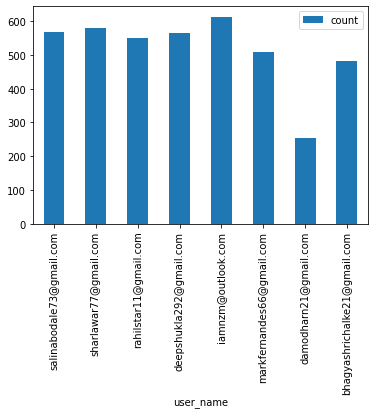

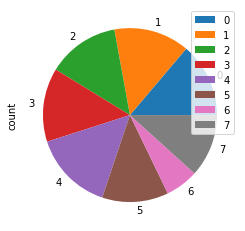

In [58]:
try:
    df = count.toPandas()
    df.plot(kind = 'bar', x='user_name', y='count')
    df.plot(kind = 'pie', x='user_name', y='count')
    plt.show()
except Exception as e:
    print(e)

***2) Finding users with highest number of average hours***

In [59]:
df = spark.read.format("csv").option("header", "true").load("hdfs://localhost:9000/csv_files/*.csv")
dfs = df.select("user_name","boot_time","keyboard","mouse")

In [60]:
df.createOrReplaceTempView("ranjith")
dfs2 = spark.sql("select user_name from ranjith where keyboard != 0 or mouse != 0").groupby("user_name").count()
dfs2.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  436|
|sharlawar77@gmail...|  457|
|rahilstar11@gmail...|  399|
|deepshukla292@gma...|  475|
|  iamnzm@outlook.com|  459|
|markfernandes66@g...|  389|
|damodharn21@gmail...|  191|
|bhagyashrichalke2...|  361|
+--------------------+-----+



In [61]:
dfs2.createOrReplaceTempView("ranjith1")
dfs3 = spark.sql("select user_name,count,((((count-1) *5)*60)/6) as wrk_hrs from ranjith1")
dfs3.show()

+--------------------+-----+-------+
|           user_name|count|wrk_hrs|
+--------------------+-----+-------+
|salinabodale73@gm...|  436|21750.0|
|sharlawar77@gmail...|  457|22800.0|
|rahilstar11@gmail...|  399|19900.0|
|deepshukla292@gma...|  475|23700.0|
|  iamnzm@outlook.com|  459|22900.0|
|markfernandes66@g...|  389|19400.0|
|damodharn21@gmail...|  191| 9500.0|
|bhagyashrichalke2...|  361|18000.0|
+--------------------+-----+-------+



In [62]:
from pyspark.sql.functions import *
highest_avg_hr = dfs3.withColumn("Minutes", round((col("wrk_hrs")/60),2))\
.withColumn("Hours", floor((col("Minutes")/60)))\
.withColumn("hourmin", floor(col("Minutes")-(col("Hours").cast("int") * 60)))\
.withColumn("Days", floor((col("Hours")/24)))\
.withColumn("Days2", col("Days")*24)\
.withColumn("average_Hrs", when((col("Hours")==0) &(col("Days")==0), concat(col("hourmin"),lit("min"))).when((col("Hours")!=0)&(col("Days")==0), concat(col("Hours"),lit(":"),col("hourmin"),lit(""))).when(col("Days")!=0, concat(col("Days"),lit("d "),(col("Hours")-col("Days2")),lit("hr "),col("hourmin"),lit("min"))))\
.drop("Minutes","Hours","hourmin","Days","Days2",'wrk_hrs')\
.orderBy(col('average_Hrs').desc())
highest_avg_hr.show()

+--------------------+-----+-----------+
|           user_name|count|average_Hrs|
+--------------------+-----+-----------+
|deepshukla292@gma...|  475|       6:35|
|  iamnzm@outlook.com|  459|       6:21|
|sharlawar77@gmail...|  457|       6:20|
|salinabodale73@gm...|  436|        6:2|
|rahilstar11@gmail...|  399|       5:31|
|markfernandes66@g...|  389|       5:23|
|bhagyashrichalke2...|  361|        5:0|
|damodharn21@gmail...|  191|       2:38|
+--------------------+-----+-----------+



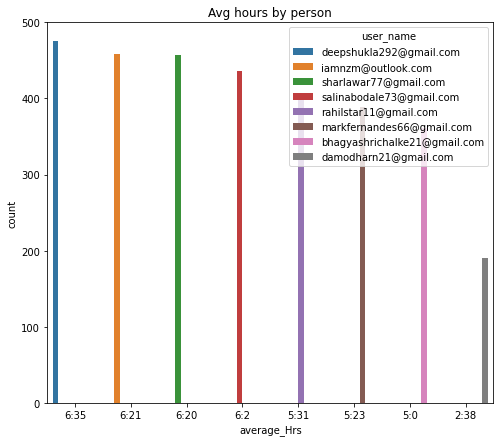

In [63]:
import seaborn as sns
from matplotlib import pyplot as plt

df = highest_avg_hr.toPandas()
plt.figure(figsize = (8,7))
sns.barplot(x = 'average_Hrs',y='count',data = df,hue='user_name')
plt.title("Avg hours by person")
plt.ylim(0,500)
plt.show()

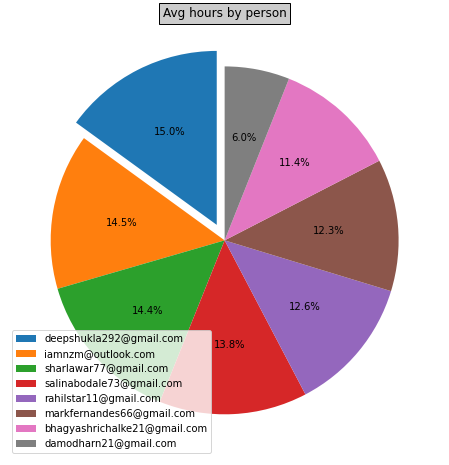

In [64]:
from matplotlib import pyplot as plt  
import pandas as pd
    
df =  highest_avg_hr.toPandas()
user_data = df["user_name"]
count_data = df["count"]

fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('w')
explode = (0.1, 0, 0, 0, 0, 0, 0, 0)
# Plot
plt.pie(count_data,autopct='%1.1f%%',startangle=90,explode=explode,)
plt.title("Avg hours by person",bbox={'facecolor':'0.8', 'pad':4})
plt.legend(user_data,loc="lower left")

***3) Finding users with lowest number of average hours***

In [65]:
from pyspark.sql.functions import *
lowest_avg_hr = dfs3.withColumn("Minutes", round((col("wrk_hrs")/60),2))\
.withColumn("Hours", floor((col("Minutes")/60)))\
.withColumn("hourmin", floor(col("Minutes")-(col("Hours").cast("int") * 60)))\
.withColumn("Days", floor((col("Hours")/24)))\
.withColumn("Days2", col("Days")*24)\
.withColumn("average_Hrs", when((col("Hours")==0) &(col("Days")==0), concat(col("hourmin"),lit("min"))).when((col("Hours")!=0)&(col("Days")==0), concat(col("Hours"),lit("."),col("hourmin"),lit(""))).when(col("Days")!=0, concat(col("Days"),lit("d "),(col("Hours")-col("Days2")),lit("hr "),col("hourmin"),lit("min"))))\
.drop("Minutes","Hours","hourmin","Days","Days2",'wrk_hrs')\
.orderBy(col('average_Hrs').asc())
lowest_avg_hr.show()

+--------------------+-----+-----------+
|           user_name|count|average_Hrs|
+--------------------+-----+-----------+
|damodharn21@gmail...|  191|       2.38|
|bhagyashrichalke2...|  361|        5.0|
|markfernandes66@g...|  389|       5.23|
|rahilstar11@gmail...|  399|       5.31|
|salinabodale73@gm...|  436|        6.2|
|sharlawar77@gmail...|  457|       6.20|
|  iamnzm@outlook.com|  459|       6.21|
|deepshukla292@gma...|  475|       6.35|
+--------------------+-----+-----------+



In [66]:
df=lowest_avg_hr.toPandas()
username= df['user_name']
hrs=df['average_Hrs']

In [67]:
colors =['Red', 'Blue', 'Green','Grey','Brown','Red','Blue','Black']
explode = (0.1, 0, 0, 0, 0, 0,0,0)

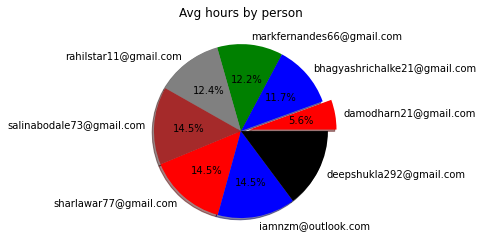

In [68]:
plt.pie(hrs, labels=username, explode=explode, colors=colors,
autopct='%1.1f%%', shadow=True)
plt.title("Avg hours by person")
plt.show()

***4) Finding users with highest numbers of idle hours***

In [69]:
df = spark.read.format("csv").option("header", "true").load("hdfs://localhost:9000/csv_files/*.csv")

In [70]:
df.createOrReplaceTempView("ranjith1")

In [71]:
dfs2 = spark.sql("select user_name from ranjith1 where keyboard = 0 and mouse = 0").groupby("user_name").count()
dfs2.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  133|
|sharlawar77@gmail...|  123|
|rahilstar11@gmail...|  152|
|deepshukla292@gma...|   90|
|  iamnzm@outlook.com|  155|
|markfernandes66@g...|  119|
|damodharn21@gmail...|   62|
|bhagyashrichalke2...|  121|
+--------------------+-----+



In [72]:
dfs2.createOrReplaceTempView("ranjith2")

In [73]:
dfs3 = spark.sql("select user_name,count, ((((count-1)*5)*60)/6) as average from ranjith2")
dfs3.show()

+--------------------+-----+-------+
|           user_name|count|average|
+--------------------+-----+-------+
|salinabodale73@gm...|  133| 6600.0|
|sharlawar77@gmail...|  123| 6100.0|
|rahilstar11@gmail...|  152| 7550.0|
|deepshukla292@gma...|   90| 4450.0|
|  iamnzm@outlook.com|  155| 7700.0|
|markfernandes66@g...|  119| 5900.0|
|damodharn21@gmail...|   62| 3050.0|
|bhagyashrichalke2...|  121| 6000.0|
+--------------------+-----+-------+



In [74]:
from pyspark.sql.functions import *
dfs4 = dfs3.withColumn("Idle_Hrs", concat(
        floor((col("average")% 86400) / 3600), lit("."),
        floor((col("average")% 86400) % 3600 / 60), lit(""),
    ))\
    .drop("average") \
    .sort(desc("Idle_Hrs"))

dfs4.show()

+--------------------+-----+--------+
|           user_name|count|Idle_Hrs|
+--------------------+-----+--------+
|  iamnzm@outlook.com|  155|     2.8|
|rahilstar11@gmail...|  152|     2.5|
|salinabodale73@gm...|  133|    1.50|
|sharlawar77@gmail...|  123|    1.41|
|bhagyashrichalke2...|  121|    1.40|
|markfernandes66@g...|  119|    1.38|
|deepshukla292@gma...|   90|    1.14|
|damodharn21@gmail...|   62|    0.50|
+--------------------+-----+--------+



In [75]:
df=dfs4.toPandas()
username= df['user_name']
hrs=df['Idle_Hrs']

In [76]:
colors =['Red', 'Blue', 'Green','Grey','Brown','Red','Blue','Black']
explode = (0.1, 0, 0, 0, 0, 0,0,0)

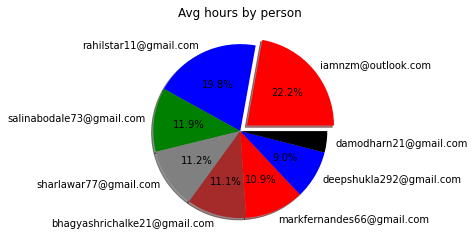

In [77]:
plt.pie(hrs, labels=username, explode=explode, colors=colors,
autopct='%1.1f%%', shadow=True)
plt.title("Avg hours by person")
plt.show()

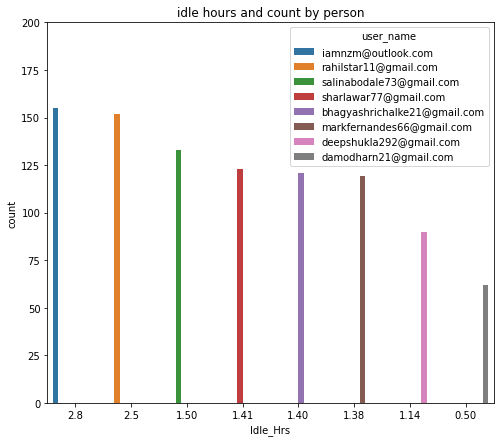

In [78]:
import seaborn as sns
from matplotlib import pyplot as plt

df = dfs4.toPandas()
plt.figure(figsize = (8,7))
sns.barplot(x = 'Idle_Hrs',y='count',data = df,hue='user_name')
plt.title("idle hours and count by person")
plt.ylim(0,200)
plt.show()

# SPARK DATAFRAME TO MYSQL DATABASE

In [79]:
import os
from loggers import logger
from dotenv import load_dotenv
load_dotenv('.env')
# set variable to be used to connect the database
database=os.getenv("DB_NAME")
user=os.getenv("DB_USER")
password=os.getenv("DB_PASSWORD")
host=os.getenv("DB_HOST")
auth_plugin=os.getenv('AUTH_PLUGIN')

In [85]:
import mysql.connector
import pandas as pd
try:
    conn = mysql.connector.connect(
                    host=host,
                    user=user,
                    password=password,
                    auth_plugin=auth_plugin,
                    database=database
                )
    cursor = conn.cursor()
    query = "SELECT * FROM highest_number_average_hours"
    #Create a pandas dataframe
    pdf = pd.read_sql(query, con=conn)
    conn.close()
    
    # Convert Pandas dataframe to spark DataFrame
    df11 = spark.createDataFrame(pdf)

except Exception as e:
    logger.error(e)
 
df11.show()

+--------------------+-----+-----------+
|           user_name|count|average_Hrs|
+--------------------+-----+-----------+
|deepshukla292@gma...|  475|       6:35|
|  iamnzm@outlook.com|  459|       6:21|
|sharlawar77@gmail...|  457|       6:20|
|salinabodale73@gm...|  436|        6:2|
|rahilstar11@gmail...|  399|       5:31|
|markfernandes66@g...|  389|       5:23|
|bhagyashrichalke2...|  361|        5:0|
|damodharn21@gmail...|  191|       2:38|
+--------------------+-----+-----------+



# SAVING SPARK DATAFRAME INTO MYSQL DATABASE

In [81]:

try:
   jdb_curl = f"jdbc:mysql://localhost:3306/"+ database
   #write the data frame into a sql table
   count.write.format("jdbc").option("url",jdb_curl) \
      .mode("overwrite")\
      .option("dbtable","user_record_count") \
      .option("driver","com.mysql.jdbc.Driver")\
      .option("user",user).option("password",password).save()
   print("written to mysql db successfully")

except Exception as e:
   logger.error(e)

In [82]:
try:
   highest_avg_hr.write.format("jdbc").option("url",jdb_curl) \
      .mode("overwrite") \
      .option("dbtable","highest_number_average_hours") \
      .option("user",user).option("password",password).save()
   print("written to mysql db successfully")

except Exception as e:
   logger.error(e)

written to mysql db successfully


In [83]:
try:
    lowest_avg_hr.write.format("jdbc").option("url",jdb_curl) \
        .mode("overwrite") \
        .option("dbtable","lowest_number_average_hours") \
        .option("user",user).option("password",password).save()
    print("written to mysql db successfully")

except Exception as e:
   logger.error(e)

written to mysql db successfully


In [84]:
try:
    dfs4.write.format("jdbc").option("url",jdb_curl) \
        .mode("overwrite") \
        .option("dbtable","highest_number_of_idle_hours") \
        .option("user",user).option("password",password).save()
    print("written to mysql db successfully")

except Exception as e:
   logger.error(e)

written to mysql db successfully
